2024-12-09  
Generation of a given quantity of samples based on the given parameters :  
$\alpha=\alpha_acos(\alpha_bt+\frac{\pi}{2})$  
$\beta=\beta_acos(\beta_bt+\frac{\pi}{2})$  
A phase might also be added in case of necessity. Though, I don't think the necessity will ever exist.

In [1]:
# Imports
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import math
import scipy.signal as signal
from numba import njit
from tqdm import tqdm
from IPython import display

# Model definition
$\frac{dx}{dt}=y$  
$\frac{dy}{dt}=-\alpha(t)\gamma^2-\beta(t)\gamma^2x-\gamma^2x^3-\gamma x^2y+\gamma^2x^2-\gamma xy$

In [2]:
# Alpha and beta
@njit
def alpha_t(t, a, b):
    return a*math.cos(b*t+(math.pi/2))

@njit
def beta_t(t, a, b):
    return a*math.cos(b*t+(math.pi/2))

# Define the system of equations
@njit
def system(z, t, args):
    gamma = args[0]
    alpha_a = args[1]
    alpha_b = args[2]
    beta_a = args[3]
    beta_b = args[4]
    x, y = z
    dxdt = y
    alpha_calc = alpha_t(t, alpha_a, alpha_b)
    beta_calc = beta_t(t, beta_a, beta_b)
    dydt = -alpha_calc*np.power(gamma, 2) - beta_calc*np.power(gamma, 2) * x - np.power(gamma, 2) * np.power(x, 3) - gamma * np.power(x, 2) * y + np.power(gamma, 2) * np.power(x, 2) - gamma * x * y
    return [dxdt, dydt]

In [3]:
# Define the resolution function
def solve_system(gamma = 10000., #test
                 alpha_a = 1.,
                 alpha_b = 1.,
                 beta_a = 1.,
                 beta_b = 1.,
                 x0 = 0.0,
                 y0 = 1.0,
                 time_length = 3,
                 sr = 44100
                 ):
    
    # Concatenation of initial conditions
    z0 = np.asarray([x0, y0])

    # Time vector
    t = np.linspace(0, time_length, math.ceil(sr*time_length))

    # Solve the system
    solution = odeint(system, z0, t, args=(np.asarray([gamma, alpha_a, alpha_b, beta_a, beta_b]),))

    # Extract the solutions
    x = solution[:, 0]
    y = solution[:, 1]

    for i in range(len(x)):
        if alpha_t(t[i], alpha_a, alpha_b) <= 0 :
            x[i] = 0

    return x, y

Sound treatment

In [4]:
#nu calculation, mean velocity
def nu(x, t):
    nu_t = np.zeros(len(x)) 
    delta_t = t[1] - t[0] #time is based on linear space => Delta(t) is a constant
    for i in range(len(x)-1) :
        nu_t[i] = (x[i+1] - x[i])/delta_t
    return nu_t

## P_in calculation
# x : input
# nu : mean velocity
# sr : sampling frequency, used to calculate delay
# T : delay (in seconds, arbitrarly chosen)
# r : reflection coefficient of the trachea (chosen arbitrarly so far)
def P_in_calculation(x, nu_t, sr, T=.01, r=.1) :
    T_i = int(T*sr)
    output = x*nu_t
    for i in range(T_i, len(output)):
        output[i] = output[i] - r*output[i-T_i]
    return output

def treat_sound(x, t, sr) :
    #p_in calculation, based on nu
    nu_t = nu(x, t)
    p_in = P_in_calculation(x, nu_t, sr, r=.3)

    # P_out
    # Parameters for the Helmholtz resonator. !!! Parameters are SI !!!
    v = 344  # Speed of sound in air (m/s)
    A = 0.0016  # Cross-sectional area of the neck (m^2)
    V = 0.000009425  # Volume of the cavity (m^3)
    L = 0.03  # Length of the neck (m)

    # Calculate the resonance frequency of the Helmholtz resonator
    f0 = (v / (2 * np.pi)) * np.sqrt(A / (V * L))
    # Create a band-pass filter around the resonance frequency
    threshold = 500 # Arbitrary chosen, might need adjustments
    lowcut = f0 - threshold  # Lower bound of the passband (Hz)
    highcut = f0 + threshold  # Upper bound of the passband (Hz)
    order = 4  # Filter order

    # Normalize filtered audio
    filtered_audio /= np.max(np.abs(filtered_audio))
    p_out = filtered_audio

    # Design the band-pass filter
    b, a = signal.butter(order, [lowcut, highcut], fs=sr, btype='band')

    # Apply the filter to the sound wave
    p_out = signal.filtfilt(b, a, p_in) + p_in*0.2

    return p_in, p_out

In [5]:
def syllable_generation(sr = 22050, #in Hz
                        time_length = 0.05, #in seconds
                        gamma = 10000.0,
                        alpha_a = 1.0,
                        alpha_b = 1.0,
                        beta_a = 1.0,
                        beta_b = 1.0,
                        x0 = 0.0,
                        y0 = 0.0,
                        ):
    x, y = solve_system(gamma, alpha_a, alpha_b, beta_a, beta_b, x0, y0, time_length, sr)
    t = np.linspace(0, time_length, math.ceil(time_length*sr))
    p_in, p_out = treat_sound(x, t, sr)
    return x, p_in, p_out

# Generation
1. Chose the maximum values of $\alpha_a$, $\alpha_b$, $\beta_a$ and $\beta_b$
2. Parameters of the generation  
2.1. Number of time steps  
2.2. Time length of the sound  
2.3. Sampling rate  
2.4. $\gamma$  
2.5. Calculation of sample length
3. Create timesteps for each variables, using ```np.linspace()``` (```np.logspace``` later ?)
4. Create empty 4D table the size of the number of time steps
5. Generate sounds using 4 for loops and keep in the array

In [6]:
# 1. Maximum values
alpha_a_range = 1
alpha_b_range = 150
beta_a_range = 1
beta_b_range = 150

# 2. Parameters
timesteps = 10
time_length = 0.3
sr = 22050
gamma = 10000.0
sample_len = math.ceil(time_length*sr)
t = np.linspace(0, time_length, math.ceil(sr*time_length))

# 3. Timesteps
t_alpha_a = np.linspace(0, alpha_a_range, timesteps)
t_alpha_b = np.linspace(0, alpha_b_range, timesteps)
t_beta_a = np.linspace(0, beta_a_range, timesteps)
t_beta_b = np.linspace(0, beta_b_range, timesteps)

# 4. Table generation
gen = timesteps
results = np.zeros((gen, gen, gen, gen, sample_len))

In [9]:
# 5. Generation
skipped = 0
total_skipped = 0
for i in range(gen) :
    pbar = tqdm(range(gen))
    for j in pbar :
        for k in range(gen) :
            for l in range(gen) :
                pbar.set_description(str(i+1) + "/" + str(gen))
                _, _, results[i][j][k][l] = syllable_generation(
                    sr, time_length, gamma, 
                    t_alpha_a[i], t_alpha_b[j], t_beta_a[k], t_beta_b[l]
                )

print("Skipped: " + str(total_skipped))

6/10 | skipped : 0: 100%|██████████| 5/5 [00:14<00:00,  2.85s/it]
7/10 | skipped : 0: 100%|██████████| 5/5 [00:14<00:00,  2.98s/it]
8/10 | skipped : 0: 100%|██████████| 5/5 [00:16<00:00,  3.21s/it]
9/10 | skipped : 0: 100%|██████████| 5/5 [00:18<00:00,  3.65s/it]
10/10 | skipped : 0: 100%|██████████| 5/5 [00:18<00:00,  3.76s/it]

Skipped: 0


In [22]:
# np.save("output/data/save_bruteforce_data6", results)

In [11]:
res_test_load = np.load("output/data/save_bruteforce_data3.npy")

In [10]:
res_test_load = results

In [11]:
for i in tqdm(range(10)):
    for j in range(10):
        for k in range(10):
            for l in range(10):
                results[i][j][k][l] = res_test_load[i][j][k][l]

100%|██████████| 10/10 [00:00<00:00, 538.07it/s]


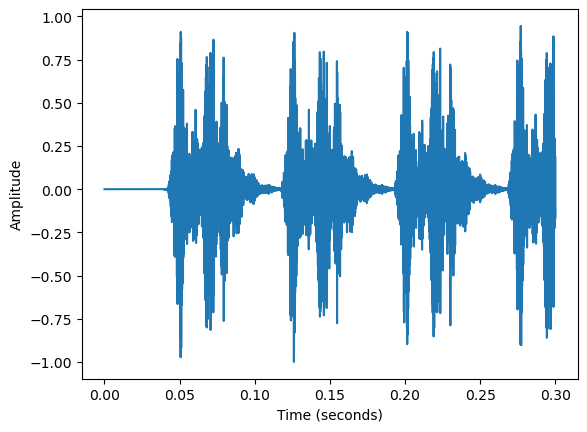

In [14]:
# Listen to one of the sound ig
test_sound = res_test_load[5][5][5][5]
# _, _, test_sound = syllable_generation(sr, time_length, gamma, 1, 100, 1, 100)
# print(np.shape(test_sound))
plt.plot(t, test_sound)
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
display.Audio(test_sound, rate=sr)